In [16]:
from visualizers import FoolingImage
from torch.autograd import Variable
import matplotlib.pyplot as plt
import numpy as np
import torchvision.transforms as T
import PIL
import torch

In [17]:
# these were the means/std from the assignment, might want to adjust
MEANS = np.array([0.485, 0.456, 0.406], dtype=np.float32)
STDDEVS = np.array([0.229, 0.224, 0.225], dtype=np.float32)


def preprocess(img, size=224):
    transform = T.Compose([
        T.Resize(size),
        T.ToTensor(),
        T.Normalize(mean=MEANS.tolist(),
                    std=STDDEVS.tolist()),
        T.Lambda(lambda x: x[None]),
    ])
    return transform(img)


def deprocess(img, should_rescale=True):
    transform = T.Compose([
        T.Lambda(lambda x: x[0]),
        T.Normalize(mean=[0, 0, 0], std=(1.0 / STDDEVS).tolist()),
        T.Normalize(mean=(-MEANS).tolist(), std=[1, 1, 1]),
        T.Lambda(rescale) if should_rescale else T.Lambda(lambda x: x),
        T.ToPILImage(),
    ])
    return transform(img)

def rescale(x):
    low, high = x.min(), x.max()
    x_rescaled = (x - low) / (high - low)
    return x_rescaled


In [20]:
# read in images

f = open("Yoga-82/yoga_test.txt");
test_lines = f.readlines();
f.close();

# choose a base pose to start from
base_class = 22
# choose a target pose
target_y = 7

# take the first image in the base pose
for entry in test_lines:
    base_pose, class6, class20, class82 = entry.split(",")
    if int(class82) == base_class:
        break

for entry in test_lines:
    target_pose, class6, class20, class82 = entry.split(",")
    if int(class82) == target_y:
        break
        

img = PIL.Image.open('./Images/Test/' + base_pose)
img_target = PIL.Image.open('./Images/Test/' + target_pose)


In [21]:
model = torch.load('./models/model_state/best_model.pt', map_location=torch.device('cpu'))

X_tensor = preprocess(img)
fi = FoolingImage()
X_fooling = fi.make_fooling_image(X_tensor, target_y, model)

In [27]:
X_tensor[0,:].shape

torch.Size([3, 359, 224])

In [42]:

scores = model(Variable(X_fooling))
predicted_class = int(scores.data.max(1)[1][0])

X_fooling_np = deprocess(X_fooling.clone())
X_fooling_np = np.asarray(X_fooling_np).astype(np.uint8)





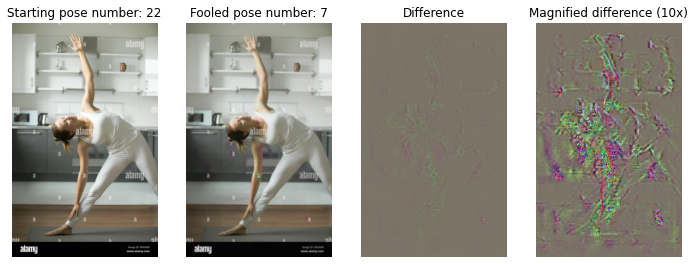

In [43]:
plt.subplot(1, 4, 1)
plt.imshow(img)
plt.title("Starting pose number: " + str(base_class))
plt.axis('off')

plt.subplot(1, 4, 2)
plt.imshow(X_fooling_np)
plt.title("Fooled pose number: " + str(predicted_class))
plt.axis('off')

plt.subplot(1, 4, 3)
X_pre = preprocess(img)
diff = np.asarray(deprocess(X_fooling - X_pre, should_rescale=False))
plt.imshow(diff)
plt.title('Difference')
plt.axis('off')

plt.subplot(1, 4, 4)
diff = np.asarray(deprocess(10 * (X_fooling - X_pre), should_rescale=False))
plt.imshow(diff)
plt.title('Magnified difference (10x)')
plt.axis('off')

plt.gcf().set_size_inches(12, 5)
plt.savefig('./visualization/fooling_image.png')
plt.show()